In [1]:
import pandas as pd
from premise.geomap import Geomap
import time
from tqdm import tqdm
import brightway2 as bw
import numpy as np
import pickle
import re
import pycountry

In [2]:
from functions_db import silent_search, extract_h2_info, run_mlca, get_year_from_name, match_year_to_database, get_conversion_factor, find_activity_fast, calculate_lca_impact # this is a python file with self-created functions needed to run this notebook
from config import *#some main key parameters needed.
from generate_figures import *
from mappings import *

## Description

In this script, we:

- Take the new IAM database containing facilities with hydrogen applications  
  (generated in `3_1_create_additional_prospective_regionalized_dbs.ipynb`);
- Calcilate all LCA results of the facilities;
- Generate the main figures.

In [3]:
bw.projects.set_current(PROJECT_NAME) #Creating/accessing the project
DB_NAME_INIT,PROJECT_NAME

('ecoinvent-3.10-cutoff', 'iea_h2_lca')

In [4]:
calc_lca_impacts = False
db_to_modify = "iea_facility_db_regionalized"

# take the IMAGE scenario, 2C:
iam_model = 'image'
new_iam_model_scenario = 'SSP2-RCP26'
new_iam_scenario = f'{iam_model}_{new_iam_model_scenario}'
DB_TO_ASSESS = f"{db_to_modify}_{new_iam_scenario}"
DB_TO_ASSESS 

'iea_facility_db_regionalized_image_SSP2-RCP26'

In [5]:
lca_acts_prod = pd.read_excel("data\LCA_act_overview.xlsx", sheet_name='h2_product', index_col = 'End use', nrows=17).fillna("nan")
lca_acts_prod_2 = lca_acts_prod.replace(np.nan, '', regex=True).reset_index(drop=True)

In [6]:
# select all hydrogen producion facilities
acts = list(bw.Database(DB_TO_ASSESS))

In [7]:
# Create the dictionary where 'act_name' is the key and a tuple of ('baseline_act', 'baseline_prod', 'baseline_loc') is the value
result_dict = {row['act_name']: (row['baseline_act'], row['baseline_prod'], row['baseline_loc']) for _, row in lca_acts_prod_2.iterrows()}
# This is for the low-carbon activities
result_dict_low = {row['act_name']: (row['baseline_act_low'], row['baseline_prod_low'], row['baseline_loc_low']) for _, row in lca_acts_prod_2.iterrows()}
dict_end_use = {row['baseline_act']: row['product_name'] for _, row in lca_acts_prod_2.iterrows()}
dict_end_use.update({'hydrogen production, steam methane reforming': "Hydrogen"})
dict_end_use.update({'market group for electricity, medium voltage': "Power"})

# to store pickly file with results
file_path = f"results/results_df_new_{iam_model}.pkl"

start_idx=0
nr_acts = len(acts)

if calc_lca_impacts:
    start_time = time.time()  # Start timing
    # Build a list of dicts, one per activity, holding all your metadata
    metadata_list = []
    geo_iam = Geomap(model=iam_model)

    # loop and collect metadata:
    for i, act_sel in enumerate(tqdm(acts[:nr_acts], desc="Collecting metadata")):
        search_loc_specific = ''
        """0. General info facility"""
        # Determine the name from the activity name substring:
        year = get_year_from_name(act_sel['name'])
    
        # Get the databases matched to the activity:
        db_name_exch = match_year_to_database(year, iam_model = f"{new_iam_scenario}") if year else ""
    
        # get the production volume
        prod_vol = act_sel.get('production volume', None)
    
        """1. BASELINE COUNTERFACTUAL"""
        # 1. --- REF BASELINE ---
        name_act_search = re.search(r"end use: '(.*?)'", act_sel['name']).group(1)
        baseline_act = result_dict[name_act_search]
        conv_factor_bau = get_conversion_factor(baseline_act)
    
        # for location-specific references, we will have to search for corresponding prospective IAM location
        if baseline_act[2] == "location specific":
            search_loc_specific = geo_iam.ecoinvent_to_iam_location(act_sel['location']) if db_name_exch!=NAME_REF_DB else act_sel['location']
            
        ref_act = find_activity_fast(
            db_name_exch,
            baseline_act[0], baseline_act[1],
            search_loc_specific if baseline_act[2] == "location specific" else baseline_act[2]
        )    
    
        """2. LOW-CARBON COUNTERFACTUAL"""
        baseline_act_low = result_dict_low[name_act_search]
        conv_factor_low = get_conversion_factor(baseline_act_low)
    
        # for location-specific references, we will have to search for corresponding prospective IAM location
        if baseline_act_low[2] == "location specific":
            search_loc_specific = geo_iam.ecoinvent_to_iam_location(act_sel['location']) if db_name_exch!=NAME_REF_DB else act_sel['location']
    
        ref_act_low = find_activity_fast(
            db_name_exch,
            baseline_act_low[0], baseline_act_low[1],
            search_loc_specific if baseline_act_low[2] == "location specific" else baseline_act_low[2]
        )

        """3. HYDROGEN"""
        # --- Hydrogen impact per kg ---
        number_kg_h2, hydrogen_source = extract_h2_info(act_sel['comment'])
        if hydrogen_source:
            act_h2_src = find_activity_fast(db_name_exch, *hydrogen_source)
        else:
            print("WARNING: No hydrogen source found")

        """Store metadata"""
        metadata = {
            'Name': act_sel['name'],
            'Year': year,
            'Country': act_sel.get('location', ''),
            "Database": db_name_exch,
            
            # Activity of facility:
            'End product': dict_end_use.get(ref_act['name'], ''),
            'production volume': prod_vol,
            'Name': act_sel.get('name', ''),
            'Unit': act_sel.get('unit', ''),
            'Reference_Product': act_sel.get('reference product', ''),
            'Facility_key': act_sel.key,
            'Activity_Name_prod': name_act_search,
            
            # Counterfactual BAU:
            'bau_activity':str(ref_act),
            'bau_activity_name':str(ref_act['name']),
            'bau_activity_key':ref_act.key,   
            'bau_conv_factor':conv_factor_bau,
            
            # Counterfactual low-carbon:
            'lc_activity':str(ref_act_low),
            'lc_activity_name':str(ref_act_low['name']),
            'lc_activity_key':ref_act_low.key,   
            'lc_conv_factor':conv_factor_low,
            
            # Hydrogen source:
            'h2_activity_key': act_h2_src.key,
            'hydrogen_source_name': str(hydrogen_source[0]),
            'kg_h2': number_kg_h2,
        }
        metadata_list.append(metadata)

    df_meta = pd.DataFrame(metadata_list)
    
    """FINALIZED METADATA COLLECTION, culculate LCA results using Multi-LCA to increase computational performance"""
    # Create a DataFrame for metadata
    mid_time = time.time()
    elapsed = mid_time - start_time
    print(f"Finished processing metadata in {elapsed:.2f} seconds. Now, calculating LCA results of facilities.")
    
    # 1. Facility LCA
    identifier_impact = '_unit'
    df_facility = run_mlca(
        activity_keys=df_meta.Facility_key,
        functional_units= [1] * len(df_meta),
        result_index_labels=df_meta.Name,
        column_suffix=identifier_impact,
        impact_methods=MY_METHODS
    )

    method = MY_METHODS[0]

    df_total = df_meta.merge(df_facility, left_on='Name', right_index=True, how='left')
    df_total[f"lca_impact_{method[1]}"] = df_total[f"lca_impact{identifier_impact}_{method[1]}"] * df_total['production volume']

    print(f"Calculating LCA results of counterfactual BAU.")
    # 2. BAU counterfactual LCA
    identifier_impact ='_ref_unit'
    df_bau = run_mlca(
        activity_keys=df_meta.bau_activity_key,
        functional_units= df_meta.bau_conv_factor,
        result_index_labels=df_meta.Name,
        column_suffix=identifier_impact,
        impact_methods=MY_METHODS
    )

    df_total = df_total.merge(df_bau, left_on='Name', right_index=True, how='left')
    df_total[f"lca_impact_ref_{method[1]}"] = df_total[f"lca_impact{identifier_impact}_{method[1]}"] * df_total['production volume']

    print(f"Calculating LCA results of counterfactual low-carbon.")
    # 3. Low-carbon counterfactual LCA
    identifier_impact ='_ref_low_unit' 
    df_lc = run_mlca(
        activity_keys=df_meta.lc_activity_key,
        functional_units= df_meta.lc_conv_factor,
        result_index_labels=df_meta.Name,
        column_suffix=identifier_impact,
        impact_methods=MY_METHODS
    )
   
    df_total = df_total.merge(df_lc, left_on='Name', right_index=True, how='left') 
    df_total[f"lca_impact_ref_low_{method[1]}"] = df_total[f"lca_impact{identifier_impact}_{method[1]}"] * df_total['production volume']

    print(f"Calculating LCA results of hydrogen production.")
    # 4.  Impact of hydrogen production only per kg:
    df_h2 = run_mlca(
        activity_keys=df_meta.h2_activity_key,
        functional_units= [1] * len(df_meta),
        result_index_labels=df_meta.Name,
        column_suffix= '_h2',
        impact_methods=MY_METHODS
    )

    results_df = df_total.merge(df_h2, left_on='Name', right_index=True, how='left')
    
    """Calculate decarb potential"""
    # Calcuate decarbonization potential:
    results_df['decarbonization_potential_Gt'] = (results_df['lca_impact_ref_climate change']-results_df['lca_impact_climate change'])/1e12
    results_df['decarbonization_potential_tCO2_tH2'] = ( (results_df['lca_impact_ref_climate change']-
                                                          results_df['lca_impact_climate change'])/1e3) / (results_df['kg_h2']/1e3)
    
    results_df['decarbonization_potential_Gt_low'] = (results_df['lca_impact_ref_low_climate change']-results_df['lca_impact_climate change'])/1e12
    results_df['decarbonization_potential_tCO2_tH2_low'] = ( (results_df['lca_impact_ref_low_climate change']-
                                                          results_df['lca_impact_climate change'])/1e3) / (results_df['kg_h2']/1e3)
    
    # Convert 'Year' column to numeric, forcing errors to NaN
    results_df['Year'] = pd.to_numeric(results_df['Year'], errors='coerce')
    
    # Now perform the comparison and assignment
    results_df.loc[results_df['Year'] < START_YEAR, 'Year'] = START_YEAR
    results_df = results_df.sort_values(by='Year', ascending=True)

    # Make just one category for CH4 applications since we dont have many facilities producing CH4 as targeted end product
    results_df['End product'] = results_df['End product'].replace('CH4 grid inj.',
                                                                  'CH4').replace('Iron&Steel', 
                                                                                 'Iron & Steel').replace('Other Ind', 
                                                                                                         'High-T heat')
    
    results_df['lca_impact_h2_total'] = results_df['lca_impact_h2_climate change'] * results_df['kg_h2']
    results_df['lca_impact_h2_spec'] = results_df['lca_impact_h2_total'] / results_df['production volume']
    
    # Save the DataFrame to a pickle file
    results_df.to_pickle(file_path)
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Finished processing in {elapsed:.2f} seconds.")
    
else:
    with open(file_path, 'rb') as file:
        results_df = pickle.load(file)    
results_df

,Name,Year,Country,Database,End product,production volume,Unit,Reference_Product,Facility_key,Activity_Name_prod,...,lca_impact_ref_climate change,lca_impact_ref_low_unit_climate change,lca_impact_ref_low_climate change,lca_impact_h2_climate change,decarbonization_potential_Gt,decarbonization_potential_tCO2_tH2,decarbonization_potential_Gt_low,decarbonization_potential_tCO2_tH2_low,lca_impact_h2_total,lca_impact_h2_spec
2679,H2 facility 'H2 Energy Europe Esbjerg green hy...,2025,DK,ecoinvent_310_reference,High-T heat,4.656558e+09,megajoule,"heat production, from hydrogen-fired one gigaw...",(iea_facility_db_regionalized_image_SSP2-RCP26...,"heat production, from hydrogen-fired one gigaw...",...,1.809930e+08,0.003042,1.416472e+07,1.552283,8.860486e-05,2.148988,-7.822345e-05,-1.897202,6.400212e+07,0.013745
1672,H2 facility 'Concrete Chemicals - II' (2025) [...,2025,DE,ecoinvent_310_reference,High-T heat,1.158569e+07,megajoule,"heat production, from hydrogen-fired one gigaw...",(iea_facility_db_regionalized_image_SSP2-RCP26...,"heat production, from hydrogen-fired one gigaw...",...,4.503176e+05,0.003042,3.524237e+04,2.206590,1.533307e-07,1.494685,-2.617445e-07,-2.551514,2.263608e+05,0.019538
1671,"H2 facility 'Aker - Rjukan, phase 1' (2025) [1...",2025,NO,ecoinvent_310_reference,High-T heat,1.956695e+08,megajoule,"heat production, from hydrogen-fired one gigaw...",(iea_facility_db_regionalized_image_SSP2-RCP26...,"heat production, from hydrogen-fired one gigaw...",...,7.605363e+06,0.003042,5.952044e+05,2.069624,2.905415e-06,1.676975,-4.104744e-06,-2.369216,3.585693e+06,0.018325
1670,H2 facility 'CorrHyd'Occ (Occitanie H2 Corrido...,2025,FR,ecoinvent_310_reference,Mobility,2.993286e+08,ton kilometer,"transport, freight, lorry, fuel cell electric,...",(iea_facility_db_regionalized_image_SSP2-RCP26...,"transport, freight, lorry, fuel cell electric,...",...,3.707627e+07,0.114590,3.429995e+07,1.864120,9.759489e-06,5.051101,6.983165e-06,3.614192,3.601761e+06,0.012033
687,H2 facility 'Bad Lauchstädt energy park' (2025...,2025,DE,ecoinvent_310_reference,Hydrogen,6.779478e+05,kilogram,"hydrogen, gaseous, 30 bar",(iea_facility_db_regionalized_image_SSP2-RCP26...,nan,...,7.197072e+06,5.804151,3.934912e+06,1.262701,6.341026e-06,9.353278,3.078866e-06,4.541456,8.560446e+05,1.262700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1926,H2 facility 'Madhya Pradesh H2' (2040) [2/5] w...,2040,IN,ecoinvent_image_SSP2-RCP26_2040_base,Mobility,5.090667e+05,ton kilometer,"transport, freight, lorry, fuel cell electric,...",(iea_facility_db_regionalized_image_SSP2-RCP26...,"transport, freight, lorry, fuel cell electric,...",...,5.030470e+04,0.054998,2.799756e+04,1.985647,1.510000e-08,4.595252,-7.207136e-09,-2.193285,6.524835e+03,0.012817
1280,H2 facility 'Green Ammonia' (2040) [1/1] with ...,2040,CO,ecoinvent_image_SSP2-RCP26_2040_base,Ammonia,1.963866e+09,kilogram,"ammonia production, hydrogen from electrolysis",(iea_facility_db_regionalized_image_SSP2-RCP26...,"ammonia production, hydrogen from electrolysis",...,6.477369e+09,0.950652,1.866953e+09,2.396913,5.259395e-03,15.216379,6.489790e-04,1.877613,8.284698e+08,0.421857
515,H2 facility 'Madhya Pradesh H2' (2040) [3/5] w...,2040,IN,ecoinvent_image_SSP2-RCP26_2040_base,Power,6.545296e+04,kilowatt hour,"electricity production, from hydrogen-fired on...",(iea_facility_db_regionalized_image_SSP2-RCP26...,"electricity production, from hydrogen-fired on...",...,3.815863e+03,0.017809,1.165680e+03,1.985647,-3.564466e-09,-1.084743,-6.214649e-09,-1.891251,6.524835e+03,0.099687
1643,"H2 facility 'NortH2, phase 2' (2040) [2/2] wit...",2040,NL,ecoinvent_image_SSP2-RCP26_2040_base,High-T heat,3.228547e+10,megajoule,"heat production, from hydrogen-fired one gigaw...",(iea_facility_db_regionalized_image_SSP2-RCP26...,"heat production, from hydrogen-fired one gigaw...",...,1.773808e+09,0.007993,2.580709e+08,0.609298,1.508442e-03,5.276708,-7.294948e-06,-0.025519,1.741789e+08,0.005

## Generate Figure 5 for IMAGE regarding the emission reduction potentials for both BAU and low-carbon counterfactual scenarios:

In [8]:
dict_criteria = {'kg_h2':'sum',
                'production volume':'sum',
                'decarbonization_potential_Gt':'sum',
                'decarbonization_potential_Gt_low':'sum',
                'decarbonization_potential_tCO2_tH2':'mean',        
                'decarbonization_potential_tCO2_tH2_low':'mean',    
                'lca_impact_climate change':'sum',          
                'lca_impact_ref_climate change':'sum',  
                'lca_impact_ref_low_climate change':'sum',
                                   }

# Load country coordinates
df_countries = pd.read_excel(r'data\df_countries.xlsx', index_col="Country Full")

# Define the coordinates for Taiwan (fallback)
taiwan_lat, taiwan_lon = 23.6978, 120.9605

def get_country_coordinates(country_name):
    """
    Get the latitude and longitude of a country by its name from df_countries.
    Returns (lat, lon) or (None, None) if not found.
    """
    try:
        return df_countries.loc[country_name].lat.item(), df_countries.loc[country_name].lon.item()
    except:
        return None, None

def get_country_name(alpha_2):
    """Convert ISO alpha-2 code to full country name."""
    try:
        return pycountry.countries.get(alpha_2=alpha_2).name
    except:
        return alpha_2

# Aggregate and prepare data
df = results_df.groupby(['Country', 'End product']).agg(dict_criteria).reset_index()
df = df.sort_values(by='decarbonization_potential_Gt_low', ascending=False)
df['decarbonization_potential_Mt'] = df['decarbonization_potential_Gt'] * 1e3
df['decarbonization_potential_Mt_low'] = df['decarbonization_potential_Gt_low'] * 1e3
df = df[['Country', 'End product', 'decarbonization_potential_Mt', 'decarbonization_potential_Mt_low', 'kg_h2']].copy()

# Map country full names and coordinates
df['Country Full'] = df['Country'].apply(get_country_name)
df['lat'], df['lon'] = zip(*df['Country Full'].apply(get_country_coordinates))

# Fill missing values for Taiwan
mask_tw = df['Country'] == 'TW'
df.loc[mask_tw, 'lat'] = df.loc[mask_tw, 'lat'].fillna(taiwan_lat)
df.loc[mask_tw, 'lon'] = df.loc[mask_tw, 'lon'].fillna(taiwan_lon)

# Print any rows still missing coordinates
print(df[df[['lat', 'lon']].isna().any(axis=1)])

# Map colors and compute total hydrogen
df['color'] = df['End product'].map(end_product_colors)
print(df.kg_h2.sum() / 1e9)

Empty DataFrame
Columns: [Country, End product, decarbonization_potential_Mt, decarbonization_potential_Mt_low, kg_h2, Country Full, lat, lon]
Index: []
109.8508704


C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


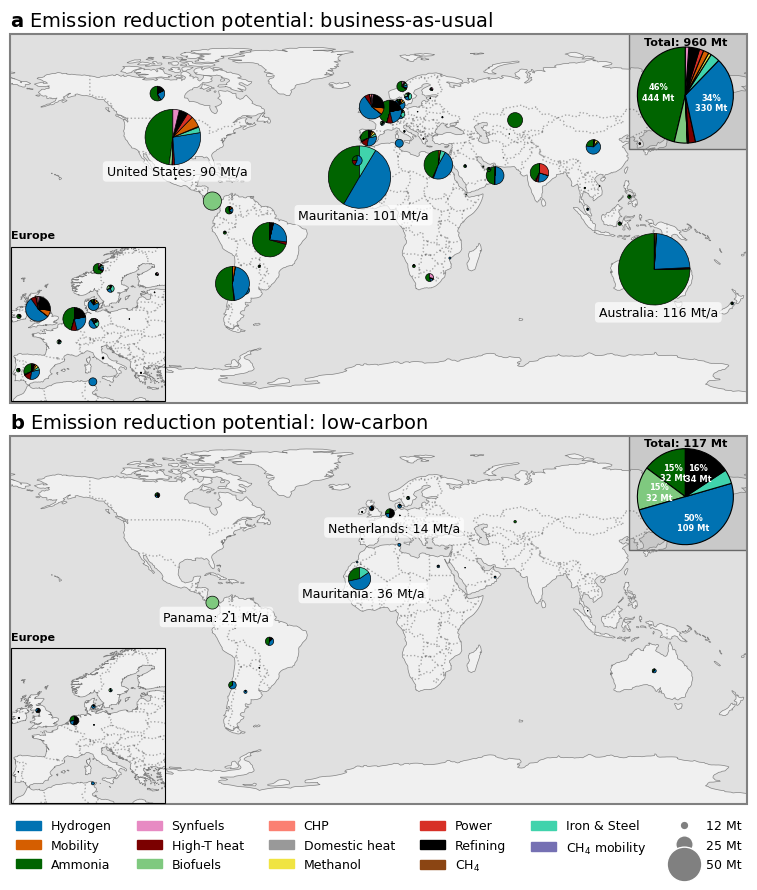

In [9]:
plot_decarbonization_potential_map(
    df=df,
    end_product_colors=end_product_colors,
    output_filepath="figs/decarbonization_potential_map_IMAGE.png",
    leg_pos = (127.08, -16.8)
)

# Generate the similar figure as Figure 3 in the main, but now for the IMAGE model:

In [10]:
dict_criteria = {'kg_h2':'sum',
                'production volume':'sum',
                'decarbonization_potential_Gt':'sum',
                'decarbonization_potential_Gt_low':'sum',
                'decarbonization_potential_tCO2_tH2':'mean',        
                'decarbonization_potential_tCO2_tH2_low':'mean',    
                'lca_impact_climate change':'sum',          
                'lca_impact_ref_climate change':'sum',  
                'lca_impact_ref_low_climate change':'sum',
                                   }


results_df_wo_ff = results_df.copy()
agg_df = results_df_wo_ff.groupby('End product').agg(dict_criteria)#.sort_values(by='decarbonization_potential_tCO2_tH2', ascending=False)
agg_df.decarbonization_potential_tCO2_tH2_low = (agg_df.decarbonization_potential_Gt_low * 1e9)	/ (agg_df.kg_h2 /1e3)
agg_df.decarbonization_potential_tCO2_tH2 = (agg_df.decarbonization_potential_Gt * 1e9)	/ (agg_df.kg_h2 /1e3)

agg_df['lca_impact_climate change_unit_ref'] = (agg_df['lca_impact_ref_climate change']) / (agg_df['production volume'])
agg_df['lca_impact_climate change_unit_ref_low'] = (agg_df['lca_impact_ref_low_climate change']) / (agg_df['production volume'])
agg_df

,kg_h2,production volume,decarbonization_potential_Gt,decarbonization_potential_Gt_low,decarbonization_potential_tCO2_tH2,decarbonization_potential_tCO2_tH2_low,lca_impact_climate change,lca_impact_ref_climate change,lca_impact_ref_low_climate change,lca_impact_climate change_unit_ref,lca_impact_climate change_unit_ref_low
End product,,,,,,,,,,,
Ammonia,3.601626e+10,2.046378e+11,0.444416,0.032364,12.339320,0.898605,2.376617e+11,6.820779e+11,2.700261e+11,3.333097,1.319531
Biofuels,5.731141e+08,1.364557e+10,0.042121,0.031773,73.494751,55.440039,4.352233e+09,4.647311e+10,3.612570e+10,3.405728,2.647430
CH4,1.272094e+08,2.553448e+08,-0.000169,-0.000955,-1.329542,-7.505392,1.105193e+09,9.360624e+08,1.504360e+08,3.665876,0.589149
CH4 mobility,4.095500e+07,1.757911e+09,0.000159,-0.000184,3.887942,-4.500804,4.185637e+08,5.777944e+08,2.342332e+08,0.328682,0.133245
CHP,1.961970e+08,1.165851e+11,0.003072,-0.000366,15.657100,-1.863945,9.430495e+08,4.014925e+09,5.773490e+08,0.034438,0.004952
Domestic heat,1.343611e+08,1.768558e+10,0.000876,-0.000295,6.522852,-2.197723,4.858236e+08,1.362241e+09,1.905349e+08,0.077026,0.010773
High-T heat,9.361842e+09,1.057311e+12,0.022079,-0.027467,2.358361,-2.933966,3.489865e+10,5.697725e+10,7.431322e+09,0.053889,0.007029
Hydrogen,3.870834e+10,3.870834e+10,0.330434,0.108914,8.536498,2.813718,9.462886e+10,4.250625e+11,2.035432e+11,10.981162,5.258381
Iron & Steel,2.594277e+09,3.873028e+10,0.030312,0.010388,11.684300,4.004038,5.908036e+10,8.939267e+10,6.946794e+10,2.308082,1.793634


In [11]:
# Calculate the impact per FU end product
results_df_wo_ff['lca_impact_climate change_unit'] = (
    results_df_wo_ff['lca_impact_climate change'] / results_df_wo_ff['production volume']
)
results_df_wo_ff['lca_impact_climate change_unit_ref'] = (
    results_df_wo_ff['lca_impact_ref_climate change'] / results_df_wo_ff['production volume']
)
results_df_wo_ff['lca_impact_climate change_unit_ref_low'] = (
    results_df_wo_ff['lca_impact_ref_low_climate change'] / results_df_wo_ff['production volume']
)


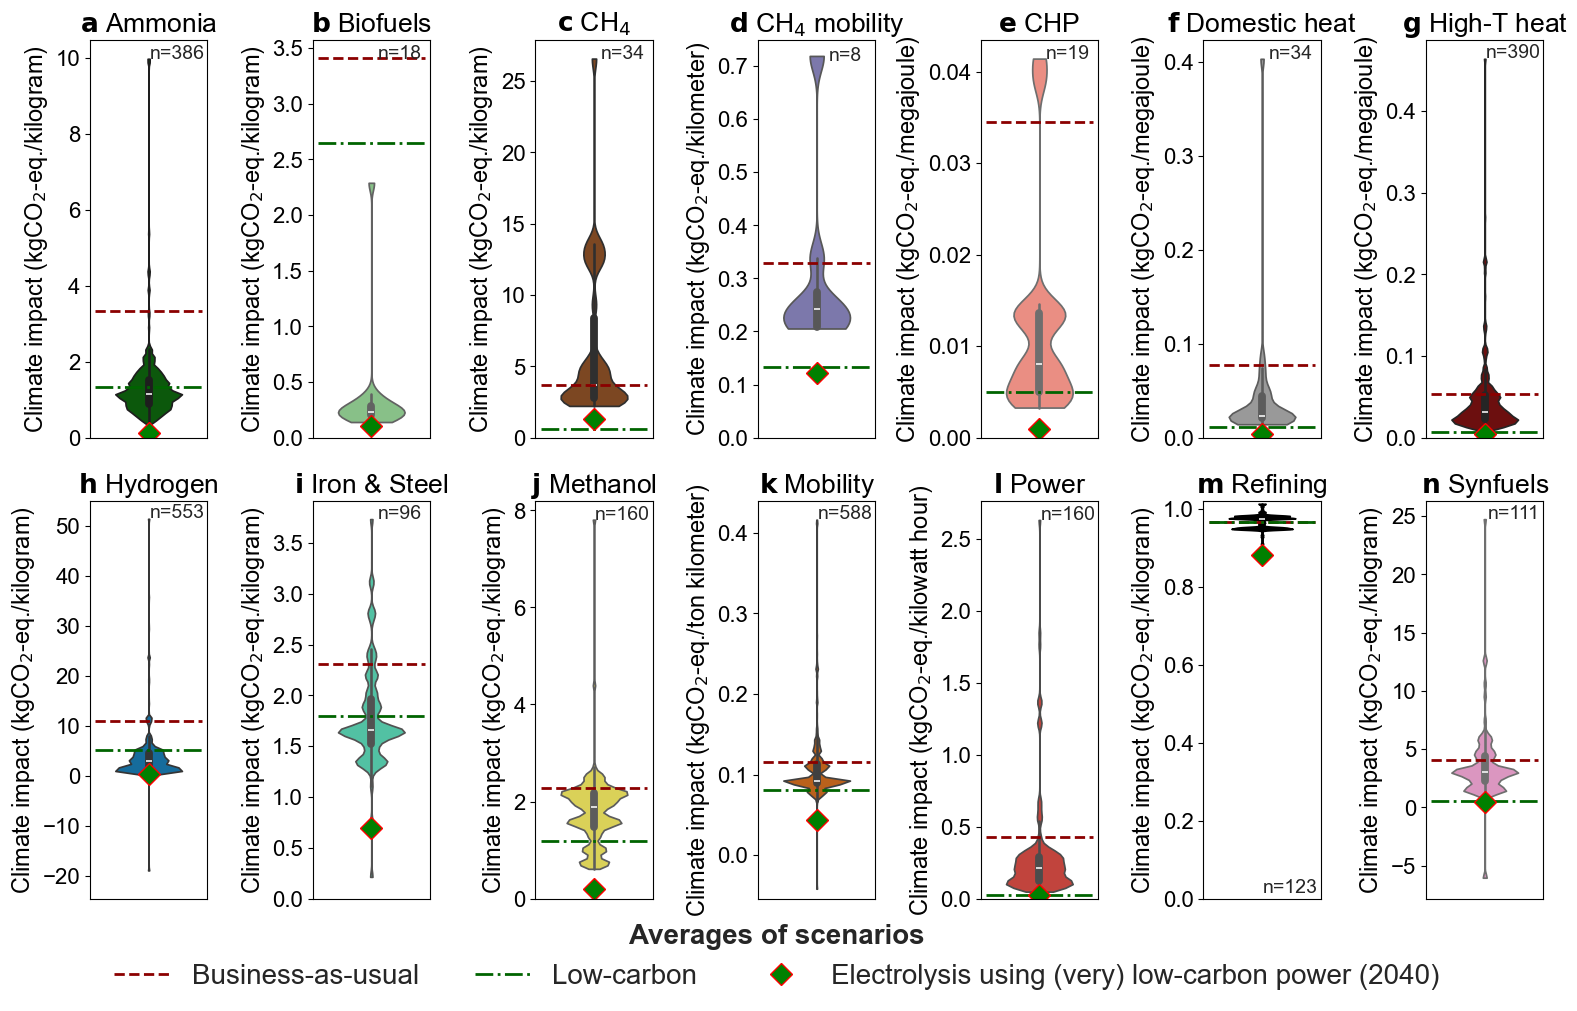

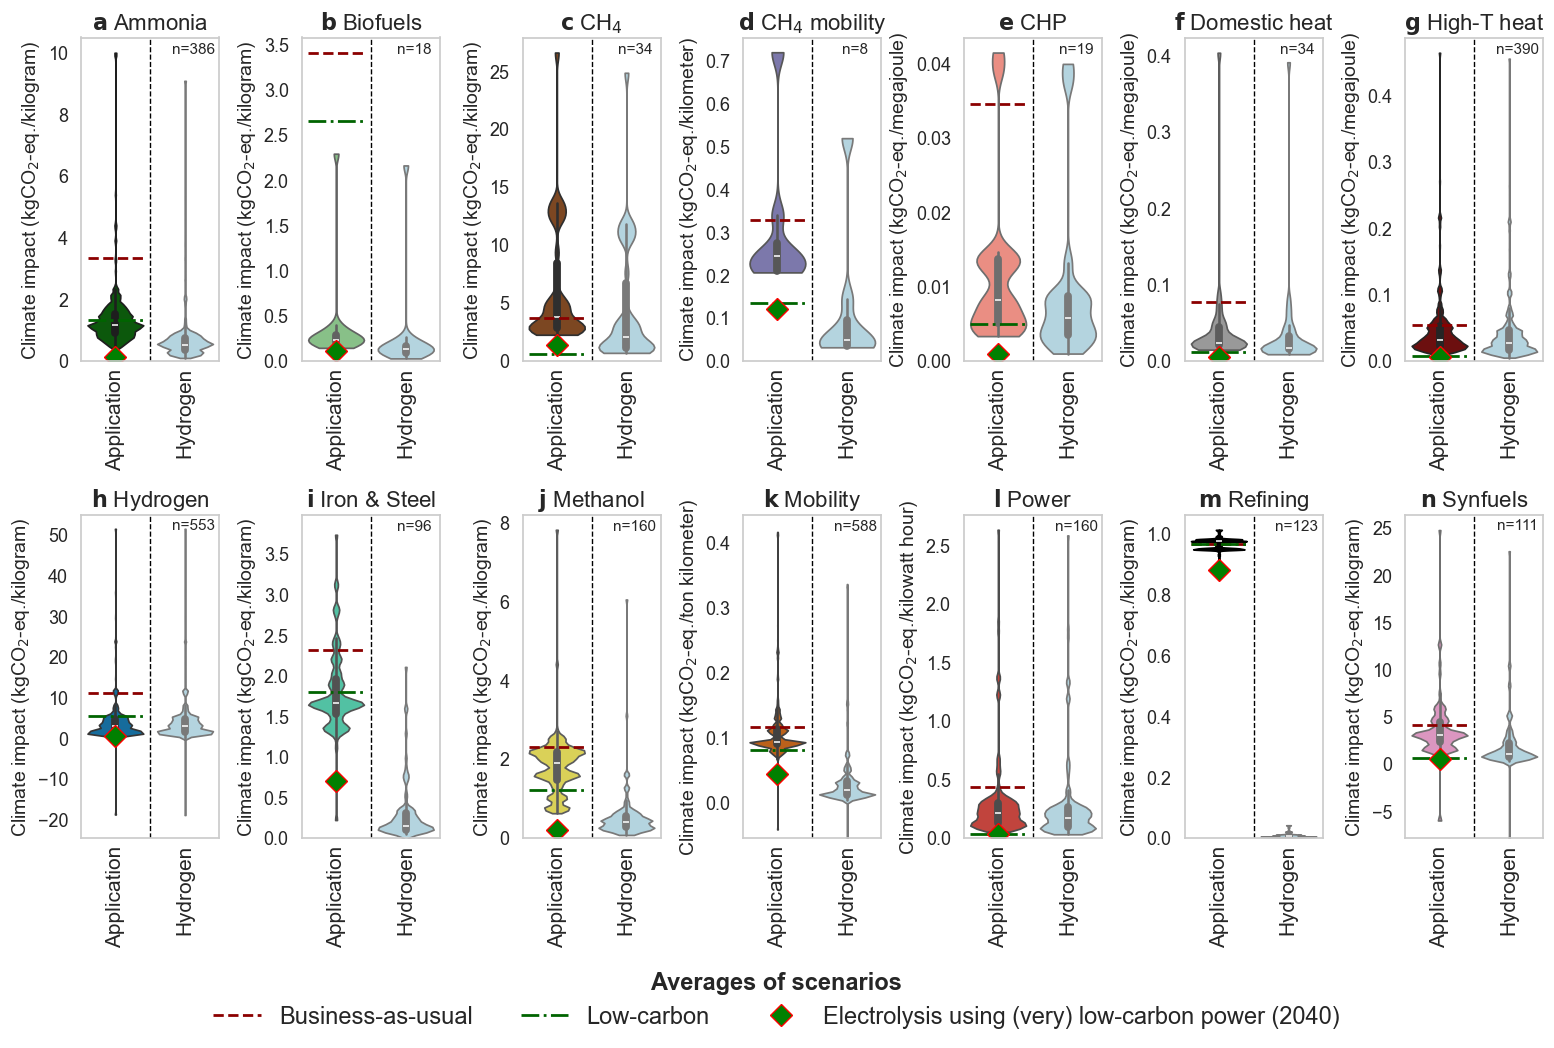

In [12]:
new_db_name_low_acts = "db_low_impact_acts_regionalized"

# List of unique end products
end_products = results_df_wo_ff['End product'].unique()

# Mapping of scenario names
scenario_labels = {
    'lca_impact_climate change_unit': 'Result',
    'lca_impact_climate change_unit_ref': 'Business-as-usual',
    'lca_impact_climate change_unit_ref_low': 'Low-carbon'
}

for font_size, show_h2_impact, height_plot in zip([20,17], [False, True], [11.3,12]):
    plot_violin_end_products(
        results_df=results_df_wo_ff,
        agg_df=agg_df,
        end_products=end_products,
        scenario_labels=scenario_labels,
        end_product_colors=end_product_colors,
        calculate_lca_impact=calculate_lca_impact,
        MY_METHODS=MY_METHODS,
        new_db_name_low_acts=new_db_name_low_acts,
        hydrogen_impact=show_h2_impact,
        height_plot = height_plot,
        font_size = font_size,
        output_path=f'figs/violinplot_end_products_cc_{show_h2_impact}_IMAGE.png'
    )

C:\Users\terlouw_t\Documents\Projects\TRANSIENCE\hydrogen_applications\generate_figures.py:491: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Scenario', y='Decarbonization Potential', data=df_prod,
C:\Users\terlouw_t\Documents\Projects\TRANSIENCE\hydrogen_applications\generate_figures.py:496: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(scenario_map.values()), rotation=90, ha='center', fontsize=font_size - 3)
C:\Users\terlouw_t\Documents\Projects\TRANSIENCE\hydrogen_applications\generate_figures.py:458: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Scenario', y='Decarbonizatio

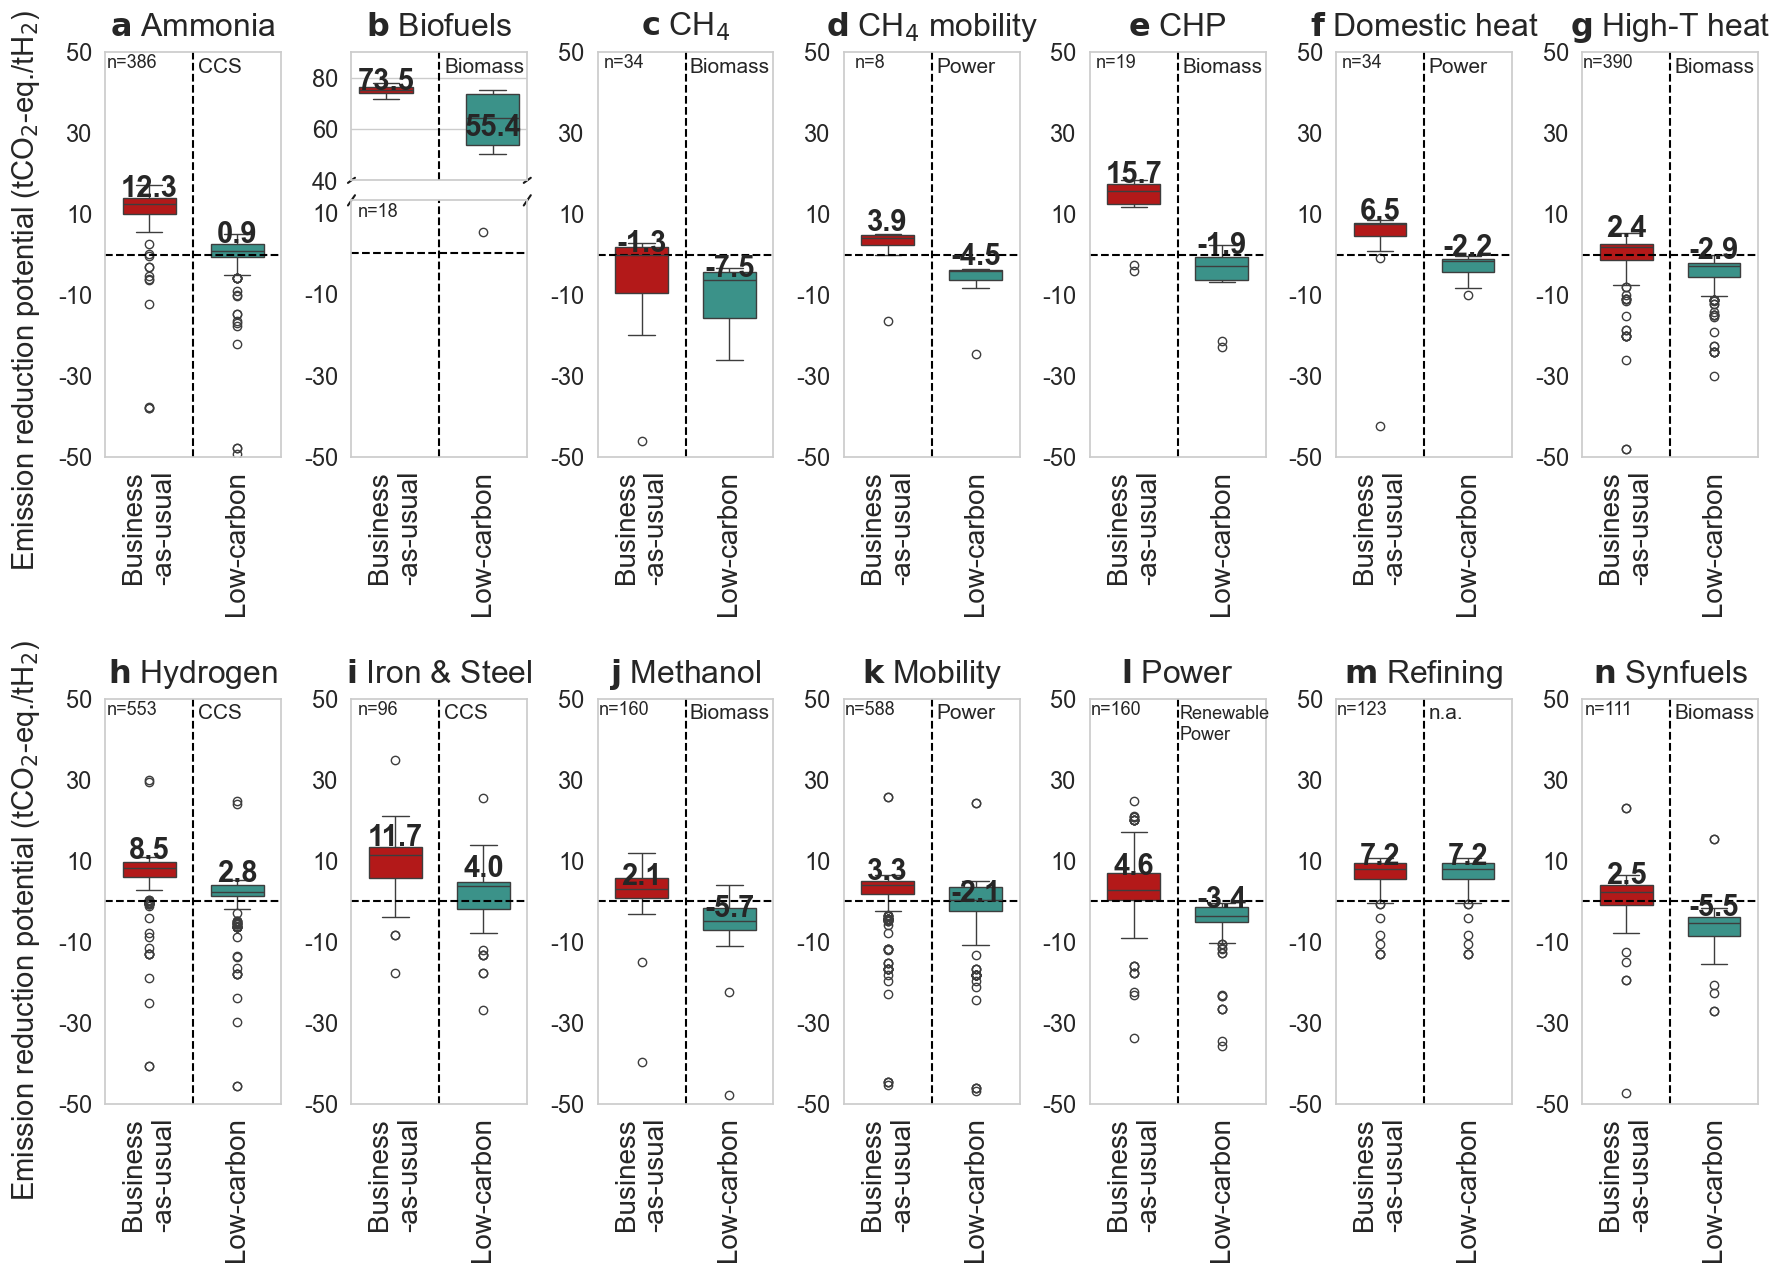

In [14]:
plot_decarbonization_potential_boxplots(results_df_wo_ff, agg_df, 
                                        replace_low_carbon_product,
                                        output_path='figs/boxplot_decarbonization_potential_IMAGE.png')